<a href="https://colab.research.google.com/github/Jameschen7/NST_with_self-attention/blob/main/NST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import time
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Neural style transfer

The implementation of the neural style transfer by [Gatys et al.](https://openaccess.thecvf.com/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) is done using PyTorch library, and follows from the two PyTorch Neural transfer tutorial [here](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html) by Alexis and [here](https://nextjournal.com/gkoehler/pytorch-neural-style-transfer) by Gregor and two other github implementations [here](https://nbviewer.jupyter.org/github/Rabona17/Neural-Style-Tranfer-From-Scratch/blob/master/Neural-Style-Transfer_From_Scratch.ipynb) by Yuan and [here](https://github.com/rpatel26/Neural-Style-Transfer) by Ravi.

### Load images and define util functions

In [83]:
# Some util functions
unloader = transforms.ToPILImage()  # reconvert into PIL image

def load_images(content_path, style_path):
    """ Load and resize content and style so that they have the same size based on the content img"""
    content_img = Image.open(content_path)
    style_img = Image.open(style_path)
    
    imsize = 512 if torch.cuda.is_available() else 128 # use small size if no gpu

    content_loader = transforms.Compose([
        transforms.Resize(imsize),  # scale imported image, either a PIL Image or a torch Tensor
        transforms.ToTensor(),  # transform it into a torch tensor, shape: C x H x W, and convert values between 0 and 255 to be between 0 and 1
        ])
    content_img = content_loader(content_img)
    style_loader = transforms.Compose([
        transforms.Resize(content_img.shape[-2:]),  # scale image based on content
        transforms.ToTensor()],
        ) 
    style_img = style_loader(style_img)

    # fake batch dimension required to fit network's input dimensions
    content_img = content_img.unsqueeze(0).to(device, torch.float)
    style_img = style_img.unsqueeze(0).to(device, torch.float)
    return content_img, style_img

def imshow(tensor, title=None, figsize=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    
    plt.ion()
    plt.figure(figsize=figsize)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated in interactive mode

def save_image(image, filepath):
    """
    image: tensor
    """
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save(filepath, 'jpeg')

def tensor_to_numpy(image):
    """
    Convert an image from tensor to ndarray by scaling up by 255 and permuting axis order
    """
    image = image.cpu().clone().squeeze(0).permute(1,2,0)*255
    image = image.detach().numpy().astype(np.uint8)
    return image

torch.Size([1, 3, 512, 512]) torch.Size([1, 3, 512, 512])


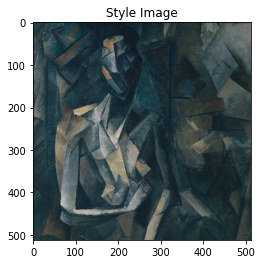

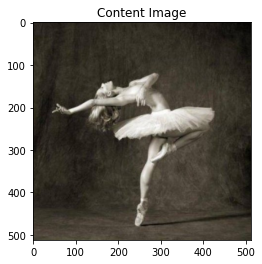

In [84]:
content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/dancing.jpg"
style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/picasso.jpg"
content_img, style_img = load_images(content_img_path, style_img_path)
print(content_img.shape, style_img.shape)
imshow(style_img, title='Style Image')
imshow(content_img, title='Content Image')

### Content loss

The content loss is defined as the weighted sum of mean squared distance between the feature maps of the content image $C^l$ and the generated image $F^l$ at layer $l$, each of size $N_l$ (# distinct filters) times $H_l \times W_l$ (size):   

$$L_{\text{content}} (C, F, l) = \frac{1}{2 N_l H_l W_l} \sum_{i,j}(F^l_{i,j} - C^l_{i,j})^2 $$

Besides, according to Gatys' paper, feature maps from lower layers in the network try to capture the exact pixel values of the input image, whereas those from higher layers contains high-level content information in terms of objects and their arrangement.

In [85]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used to dynamically compute the gradient: 
        # this is a stated value, not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach().clone()

    def forward(self, input):
        loss = F.mse_loss(input, self.target)
        # print("c", loss)
        return loss

### Style loss
Here the code uses the Gram matrix for style representation. A gram matrix is the result of multiplying a given matrix by its transposed matrix, and here it can capture the correlations between different filter responses at each position over the compared images. The style loss will be a weighed sum of the mean square error between the Gram matrix $G^l \in \mathbb{R}^{N_l \times N_l}$ of the generated image and the Gram matrix $S^l$ of the style image feature maps at layer $l$, each of size $N_l$ (# distinct filters) times $H_l \times W_l$ (size):   

$$ G^l_{i,j} = <F^l_i, F^l_j> $$
$$ L_{\text{style}}(S, F, l) = \frac{1}{4N_l^2(H_l W_l)^2} \sum_{i,j} (G^l_{i,j} - S^l_{i,j})^2 $$

Based on Gatys, the correlations of feature maps from multiple layers provide a "stationary, multi-scale representation" and "texture information but not the global arrangement" of the images. Using feature maps up to a higher layer discards more global arrangement of the scene and captures the style at larger scale. 

In [86]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1); b=# feature maps; (c,d)=dimensions of a f. map
    features = input.view(b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach().clone() # the Gram matrix of style image is fixed

    def forward(self, input):
        G = gram_matrix(input)
        loss = F.mse_loss(G, self.target)
        # print("s:", loss)
        return loss

### Attention-based style loss

The self-attention module uses the Gaussian function without any embedding space:

\begin{equation}
f(x_i,x_j) = e^{x_i^T x_j}
\end{equation}

A new style target feature maps $FA$ is created where each position becomes a linear combination of the style image responses $A^l$ with weights based on the dot-product similarity to the content image responses $C^l$ at this location through the softmax function for each interested layer $l$:

\begin{equation}
FA^l_{i} = \frac{1}{\textbf{C}(FA)} \sum_{\forall j} {f(\overline{C^l_i}, \overline{A^l_j})A^l_j}
\end{equation}

\begin{equation}
\textbf{C}(FA) = \sum_{\forall j} {f(\overline{C^l_i}, \overline{A^l_j})}
\end{equation}

where $i$ denotes a pair of coordinates on the output matrix, and $j$ enumerates all positions on the style image feature map in matrix form, $\textbf{C}$ represents the softmax normalization factor, and the bar indicates the matrix is mean normalized. Here we do not choose to normalize variance as well like SANet because experiment shows that the synthesized image owns more detail and texture in this way. Comparing the Gram matrix of the new target style feature map $FA$ and the generated image feature map $F$, our attention-based style loss is defined as:

\begin{equation}
L_{attention\_style}(FA, F, l) = L_{style}(SA, G, l)
\end{equation}

where $SA$ is the Gram matrix style representation from $FA$, and $G$ is that using $F$.


In [87]:
class AttentionStyleLoss(nn.Module):
    def __init__(self, content_feature, style_feature):
        super(AttentionStyleLoss, self).__init__()
        content_feature = content_feature.detach().clone()
        style_feature = style_feature.detach().clone()
        N,C,H,W = style_feature.shape
        style_feature = style_feature.view(H*W, C)
        # print("max style_feature:", torch.max(style_featue))
        content_feature = content_feature.view(H*W, C)
        # print("max content_feature:", torch.max(content_feature))
        # print("max softmax 0.5:", torch.max(torch.mm(style_feature, content_feature)))
        softmax = torch.mm(content_feature, style_feature.T)
        softmax /= torch.max(softmax)//10
        softmax = torch.exp(softmax)
        # print("nan softmax 1:", torch.sum(softmax != softmax))
        # print("max softmax 1:", torch.sum(softmax))
        # print("max softmax 1.5:", torch.max(torch.sum(softmax, dim=1, keepdim=True)), torch.min(torch.sum(softmax, dim=1, keepdim=True)))
        softmax = softmax / (torch.sum(softmax, dim=1, keepdim=True) + 1e-8) # add episilon to prevent division by zero
        # print("nan softmax 2:", torch.sum(softmax != softmax))
        # print("max softmax 2:", torch.max(softmax))
        print(softmax.shape, style_feature.shape)
        y = torch.mm(softmax, style_feature) # new style feature with weight based on similarity
        # print("nan softmax 3:", torch.sum(y != y))
        # print("max y:", torch.max(y))
        y = y.view(N,C,H,W)
        y = (y - torch.mean(y, [2,3], keepdim=True) ) #/torch.std(y, [2,3], keepdim=True)
        # self.target = gram_matrix(y)
        self.target = y
    
    def forward(self, input):
        G = gram_matrix(input)
        # print(input.shape, self.target.shape)
        loss = F.mse_loss(G, gram_matrix(self.target))
        # loss = F.mse_loss(input, self.target)
        # print(loss.item(), G.shape, gram_matrix(self.target).shape, torch.mean(G), torch.mean(gram_matrix(self.target)))
        # print("s:", loss)
        return loss

In [88]:
# # v2 the version 2 was used to explore new ideas like comparing features from the second or the six layer using up/downsampling
# class AttentionStyleLoss2(nn.Module):
#     def __init__(self, content_feature, style_feature, style_feature_use):
#         super(AttentionStyleLoss, self).__init__()
#         content_feature = content_feature.detach().clone()
#         style_feature = style_feature.detach().clone()
#         style_feature_use = style_feature_use.detach().clone()
#         N,C,H,W = style_feature.shape
#         N2,C2,H2,W2 = style_feature_use.shape
#         print(H, W, H2, W2)
#         print(style_feature_use.shape)
#         style_feature = style_feature.view(H*W, C)
#         # style_feature_use = style_feature_use.view(H2*W2, C2)
#         content_feature = content_feature.view(H*W, C)
#         # print("max content_feature:", torch.max(content_feature))
#         # print("max softmax 0.5:", torch.max(torch.mm(style_feature, content_feature)))
#         softmax = torch.mm(content_feature, style_feature.T)
#         softmax /= torch.max(softmax)//10
#         softmax = torch.exp(softmax)
#         # print("nan softmax 1:", torch.sum(softmax != softmax))
#         # print("max softmax 1:", torch.sum(softmax))
#         # print("max softmax 1.5:", torch.max(torch.sum(softmax, dim=1, keepdim=True)), torch.min(torch.sum(softmax, dim=1, keepdim=True)))
#         softmax = softmax / (torch.sum(softmax, dim=1, keepdim=True) + 1e-8) # add episilon to prevent division by zero
#         # print("nan softmax 2:", torch.sum(softmax != softmax))
#         # print("max softmax 2:", torch.max(softmax))
#         softmax = F.upsample(softmax.unsqueeze(0).unsqueeze(0), scale_factor=1/4, mode="nearest").squeeze()
#         style_feature_use = F.upsample(style_feature_use, scale_factor=1/2, mode="nearest").view((H2//2)*(W2//2), C2)
#         print(softmax.shape, style_feature_use.shape)
#         y = torch.mm(softmax, style_feature_use) # new style feature with weight based on similarity
#         # print("nan softmax 3:", torch.sum(y != y))
#         # print("max y:", torch.max(y))
#         y = y.view(N2,C2,H2//2,W2//2)
#         y = y - torch.mean(y, [2,3], keepdim=True) 
#         # self.target = gram_matrix(y)
#         self.target = y
    
#     def forward(self, input):
#         input = F.upsample(input, scale_factor=1/4, mode="nearest")
#         G = gram_matrix(input)
#         loss = F.mse_loss(G, gram_matrix(self.target))
#         # loss = F.mse_loss(input, self.target)
#         # print(input.shape, self.target.shape)
#         # print(loss.item(), G.shape, gram_matrix(self.target).shape, torch.mean(G), torch.mean(gram_matrix(self.target)))
#         # print("Attention style forward:", loss)
#         return loss

In [89]:
a = torch.tensor([[1,2],[3,4]])
torch.sum(a, dim=1, keepdim=True)

tensor([[3],
        [7]])

### Total loss
The total loss will just jointly minimize the content loss, the style loss, and the attention-based style loss.

$$
L_{total}(C, S, FA, F) = \alpha \sum_l w^{cl}L_{content}(C,F,l) +
\beta \sum_l w^{sl} L_{style}(S, F, l) + \gamma \sum_l w^{al} L_{style}(FA, F, l)
$$

In [90]:
# with attention style loss
class TotalLoss(nn.Module): 
    def __init__(self, content_img_features, style_img_features, attention_cont_features, attention_style_features, 
                 content_layer_weights, style_layer_weights, attention_layer_weights, alpha, beta, attention_weight):
        super(TotalLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.attention_weight = attention_weight
        self.content_layer_weights = content_layer_weights
        self.style_layer_weights = style_layer_weights
        self.attention_layer_weights = attention_layer_weights

        self.content_loss_mods = []
        self.style_loss_mods = []
        self.attention_style_loss_mods = []
        for content_feature in content_img_features.values():
            self.content_loss_mods.append(ContentLoss(content_feature))
        for style_feature in style_img_features.values():
            self.style_loss_mods.append(StyleLoss(style_feature))
        for attention_cont_feature, attention_style_feature in zip(attention_cont_features.values(), attention_style_features.values()):
            self.attention_style_loss_mods.append(AttentionStyleLoss(attention_cont_feature, attention_style_feature))
        print(f"# content layer: {len(content_img_features)}, # style layer: {len(style_img_features)}, # attention layer: {len(attention_cont_features)}")

    def forward(self, content_features, style_features, attention_features):
        content_loss, style_loss = 0, 0
        attention_style_loss = 0
        for feature, c_loss_mod, layer_weight in zip(content_features.values(), self.content_loss_mods, self.content_layer_weights):
            content_loss += layer_weight * c_loss_mod(feature)
        for feature, s_loss_mod, layer_weight in zip(style_features.values(), self.style_loss_mods, self.style_layer_weights):
            # display(feature.shape, layer_weight, s_loss_mod(feature))
            style_loss += layer_weight * s_loss_mod(feature) 
        for feature, a_loss_mod, layer_weight in zip(attention_features.values(), self.attention_style_loss_mods, self.attention_layer_weights):
            # print(len(self.attention_style_loss_mods), len(attention_features.values()), feature.shape, a_loss_mod(feature).item())
            attention_style_loss += layer_weight * a_loss_mod(feature) 

        total_loss = self.alpha * content_loss + self.beta * style_loss + self.attention_weight * attention_style_loss 
        # print((self.alpha * content_loss).item(), (self.beta * style_loss).item())
        self.content_score = (self.alpha * content_loss).item()
        self.style_score = (self.beta * style_loss).item()
        self.attention_style_score = (self.attention_weight * attention_style_loss)
        return total_loss

In [91]:
# # with attention style loss 2
# class TotalLoss(nn.Module): 
#     def __init__(self, content_img_features, style_img_features, attention_cont_cont_features, attention_style_cont_features, attention_style_style_features,
#                  content_layer_weights, style_layer_weights, attention_layer_weights, alpha, beta, attention_weight):
#         super(TotalLoss, self).__init__()
#         self.alpha = alpha
#         self.beta = beta
#         self.attention_weight = attention_weight
#         self.content_layer_weights = content_layer_weights
#         self.style_layer_weights = style_layer_weights
#         self.attention_layer_weights = attention_layer_weights

#         self.content_loss_mods = []
#         self.style_loss_mods = []
#         self.attention_style_loss_mods = []
#         for content_feature in content_img_features.values():
#             self.content_loss_mods.append(ContentLoss(content_feature))
#         for style_feature in style_img_features.values():
#             self.style_loss_mods.append(StyleLoss(style_feature))
#         for attention_cont_feature, attention_style_feature, attention_ss_feature in zip(attention_cont_cont_features.values(), 
#                                                                    attention_style_cont_features.values(), attention_style_style_features.values()):
#             print("in total init:",attention_ss_feature.shape)
#             self.attention_style_loss_mods.append(AttentionStyleLoss(attention_cont_feature, attention_style_feature, attention_ss_feature))
#         # print(f"# content layer: {len(content_img_features)}, # style layer: {len(style_img_features)}, # attention layer: {len(attention_cont_features)}")
#         print(f"# content layer: {len(content_img_features)}, # style layer: {len(style_img_features)}, # attention layer: {len(attention_style_style_features)}")

#     def forward(self, content_features, style_features, attention_features, attention_use_features):
#         content_loss, style_loss = 0, 0
#         attention_style_loss = 0
#         for feature, c_loss_mod, layer_weight in zip(content_features.values(), self.content_loss_mods, self.content_layer_weights):
#             content_loss += layer_weight * c_loss_mod(feature)
#         for feature, s_loss_mod, layer_weight in zip(style_features.values(), self.style_loss_mods, self.style_layer_weights):
#             # display(feature.shape, layer_weight, s_loss_mod(feature))
#             style_loss += layer_weight * s_loss_mod(feature) 
#         for feature, a_loss_mod, layer_weight in zip(attention_use_features.values(), self.attention_style_loss_mods, self.attention_layer_weights):
#             # print(len(self.attention_style_loss_mods), len(attention_features.values()), feature.shape, a_loss_mod(feature).item())
#             # print("in for loop:", a_loss_mod(feature) , layer_weight)
#             attention_style_loss += layer_weight * a_loss_mod(feature) 

#         total_loss = self.alpha * content_loss + self.beta * style_loss + self.attention_weight * attention_style_loss 
#         self.content_score = (self.alpha * content_loss).item()
#         self.style_score = (self.beta * style_loss).item()
#         self.attention_style_score = (self.attention_weight * attention_style_loss)
#         # print((self.alpha * content_loss).item(), (self.beta * style_loss).item(), self.attention_weight * attention_style_loss)
#         return total_loss

### Deep Convolutional Neural Networks
A pre-trained VGG-19 network like the one used in Gatys' paper can effectively learn the low-level and high-level semantic features in different images 

In [92]:
# PyTorch’s implementation of VGG is a module divided into two child Sequential modules: 
# features (containing convolution and pooling layers), 
# and classifier (containing fully connected layers). 
cnn = models.vgg19(pretrained=True).features.to(device).eval() # only need features part 
for param in cnn.parameters():
    param.requires_grad_(False)

# a trick suggested by Gregor as it's used by Gatys
for i, layer in enumerate(cnn):
    if isinstance(layer, torch.nn.MaxPool2d):
        cnn[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [93]:
list(cnn.named_children())

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', ReLU(inplace=True)),
 ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', ReLU(inplace=True)),
 ('4', AvgPool2d(kernel_size=2, stride=2, padding=0)),
 ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', ReLU(inplace=True)),
 ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', ReLU(inplace=True)),
 ('9', AvgPool2d(kernel_size=2, stride=2, padding=0)),
 ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', ReLU(inplace=True)),
 ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', ReLU(inplace=True)),
 ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('15', ReLU(inplace=True)),
 ('16', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('17', ReLU(inplace=True)),
 ('18', AvgPool2d(kernel_size=2, stride=2, paddi

Extract feature maps by manually going through the model and save the wanted layer after mean normalization.

In [94]:
# Additionally, VGG networks are trained on images with each channel normalized by 
# mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
# We will use them to normalize the image before sending it into the network.
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

def get_features(image, cnn, content_layer:"dict", style_layer:"dict", attention_style_layer):
    content_features = {}
    style_features = {}
    attention_features = {}
    x = normalization(image)
    for name, layer in enumerate(cnn):
        x = layer(x)
        if name in [0, 5, 10, 19, 28]:
        # if isinstance(layer, nn.Conv2d):
            x = x - torch.mean(x, [2,3], keepdim=True) 
        if str(name) in content_layer:
            # content_features[content_layer[str(name)]] = x.clone()
            feature_map = x.clone()
            # feature_map = feature_map - torch.mean(feature_map, [2,3], keepdim=True) 
            # x = feature_map
            content_features[content_layer[str(name)]] = feature_map
        if str(name) in style_layer:
            # style_features[style_layer[str(name)]] = x.clone()
            feature_map = x.clone()
            # feature_map = feature_map - torch.mean(feature_map, [2,3], keepdim=True) 
            # x = feature_map
            style_features[style_layer[str(name)]] = feature_map
        if str(name) in attention_style_layer:
            feature_map = x.clone()
            # normalize
            feature_map = (feature_map - torch.mean(feature_map, [2,3], keepdim=True)) / (torch.std(feature_map, [2,3], keepdim=True) + 1e-10)
            # feature_map = F.instance_norm(feature_map)
            # print("in get feature_map:", torch.max(feature_map))
            attention_features[attention_style_layer[str(name)]] = feature_map
    return content_features, style_features, attention_features

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [95]:
# # Additionally, VGG networks are trained on images with each channel normalized by 
# # mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
# # We will use them to normalize the image before sending it into the network.
# cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
# cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# class Normalization(nn.Module):
#     def __init__(self, mean, std):
#         super(Normalization, self).__init__()
#         self.mean = torch.tensor(mean).view(-1, 1, 1)
#         self.std = torch.tensor(std).view(-1, 1, 1)

#     def forward(self, img):
#         return (img - self.mean) / self.std

# normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)

# def get_features(image, cnn, content_layer:"dict", style_layer:"dict", attention_style_layer, attention_style_use_layer):
#     content_features = {}
#     style_features = {}
#     attention_features = {}
#     attention_style_use_features = {}
#     x = normalization(image)
#     for name, layer in enumerate(cnn):
#         x = layer(x)
#         if name in [0, 5, 10, 19, 28]:
#         # if isinstance(layer, nn.Conv2d):
#             x = x - torch.mean(x, [2,3], keepdim=True) 
#             # x = F.instance_norm(x)
#         if str(name) in content_layer:
#             # content_features[content_layer[str(name)]] = x.clone()
#             feature_map = x.clone()
#             # feature_map = feature_map - torch.mean(feature_map, [2,3], keepdim=True) 
#             # x = feature_map
#             content_features[content_layer[str(name)]] = feature_map
#         if str(name) in style_layer:
#             # style_features[style_layer[str(name)]] = x.clone()
#             feature_map = x.clone()
#             # feature_map = feature_map - torch.mean(feature_map, [2,3], keepdim=True) 
#             # x = feature_map
#             style_features[style_layer[str(name)]] = feature_map
#         if str(name) in attention_style_layer:
#             feature_map = x.clone()
#             # feature_map = (feature_map - torch.mean(feature_map, [2,3], keepdim=True)) / (torch.std(feature_map, [2,3], keepdim=True) + 1e-10)
#             # print("in get feature_map:", torch.max(feature_map))
#             attention_features[attention_style_layer[str(name)]] = feature_map
#         if str(name) in attention_style_use_layer:
#             feature_map = x.clone()
#             feature_map = (feature_map - torch.mean(feature_map, [2,3], keepdim=True)) # / (torch.std(feature_map, [2,3], keepdim=True) + 1e-10)
#             # print("in get feature_map:", torch.max(feature_map))
#             attention_style_use_features[attention_style_use_layer[str(name)]] = feature_map
#     return content_features, style_features, attention_features, attention_style_use_features

### Model
Combine everything together and define a function to train the input image

<Figure size 432x288 with 0 Axes>

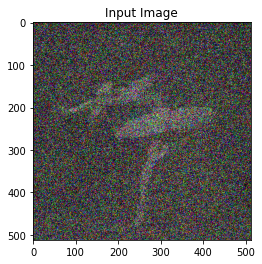

In [97]:
# Initialize an image by adding some white noise onto the original content image
def initialize_img(content_img, noise_ratio=0.6):
    input_img = content_img.clone()
    noise_img = torch.randn(content_img.data.size(), device=device)
    noise_ratio = noise_ratio
    input_img = noise_ratio * noise_img + (1 - noise_ratio) * input_img
    input_img.data.clamp_(0, 1)
    return input_img.requires_grad_()

input_img = initialize_img(content_img)
# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

Use L-BFGS algorithm to run our gradient descent

In [98]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [99]:
#v2
# def run_style_transfer(cnn, content_img, style_img, num_steps=300, noise_ratio=0.6,
#                        content_weight=1, style_weight=1000000, attention_weight=1e4,
#                        content_layer=None, style_layer=None, attention_style_layer=None, attention_style_use_layer=None,
#                        content_layer_weights=None, style_layer_weights=None, attention_layer_weights=None):
#     print('Building the style transfer model..')
#     if content_layer is None:  # provide the default layers used by Gatys' paper,
#         content_layer = {     
#             '21': 'conv4_2',  
#             }
#     if style_layer is None: 
#         style_layer = {
#             '0': 'conv1_1',
#             '5': 'conv2_1',
#             '10': 'conv3_1',
#             '19': 'conv4_1',
#             '28': 'conv5_1'
#             }
#     if attention_style_layer is None: 
#         attention_style_layer={
#             '19': 'conv4_1',
#             # '28': 'conv5_1'
#         }
#     # default equal weight
#     if content_layer_weights is None:
#         content_layer_weights = np.full(len(content_layer), 1/len(content_layer))
#     if style_layer_weights is None:
#         style_layer_weights = np.full(len(style_layer), 1/len(style_layer))
#     if attention_layer_weights is None:
#         attention_layer_weights = np.full(len(attention_style_layer), 1/len(attention_style_layer))
#     print(content_layer_weights, style_layer_weights, attention_layer_weights, attention_style_use_layer)

#     # now we trim off the layers after the last content and style losses
#     cnn = copy.deepcopy(cnn)
#     for i in range(len(cnn) - 1, -1, -1):
#         if str(i) in content_layer or str(i) in style_layer or str(i) in attention_style_layer or str(i) in attention_style_use_layer:
#             break
#     cnn = cnn[:(i + 1)]

#     # calculate the features for the content and style images and set up the loss module
#     content_features, _,  content_attention_features, _ = get_features(content_img, cnn, content_layer, style_layer, attention_style_layer, attention_style_use_layer)
#     style_content_features, style_features, style_attention_features, attention_style_use_features = get_features(style_img, cnn, content_layer, style_layer, attention_style_layer, attention_style_use_layer)
#     total_loss = TotalLoss(content_features, style_features, content_attention_features, style_attention_features, attention_style_use_features,
#                            content_layer_weights, style_layer_weights, attention_layer_weights,
#                             content_weight, style_weight, attention_weight)
#     # total_loss = TotalLoss(content_features, style_features, content_attention_features, style_attention_features, 
#     #                        content_layer_weights, style_layer_weights, attention_layer_weights,
#     #                         content_weight, style_weight, attention_weight)

#     # Optimize the image
#     input_img = initialize_img(content_img, noise_ratio=noise_ratio)
#     optimizer = get_input_optimizer(input_img) # LBFGS seems to be faster
#     # optimizer = optim.Adam([input_img], lr=0.01)

#     start = time.time()
#     run = [-1] # in a list so that the LBFGS can modify and keep it
#     while run[0] <= num_steps+1:
#         def closure(): # define a closure method for the 
#             input_img.data.clamp_(0, 1)
#             optimizer.zero_grad()
#             input_content_features, input_style_features, input_attention_features, input_attention_use_features = get_features(input_img, cnn, content_layer, style_layer, attention_style_layer, attention_style_use_layer)
#             loss = total_loss(input_content_features, input_style_features, input_attention_features, input_attention_use_features)
#             # calculate the Total Variation Denoising term (minimize the different if shift 1 px by x or y)
#             # denoise = 0
#             denoise =  torch.mean((input_img[:, :, 1:, :] - input_img[:,:, :-1,:]).abs()) + \
#                             torch.mean((input_img[:, :, :, 1:] - input_img[:,:, :, :-1]).abs())
#             loss += denoise/2
#             loss.backward() 

#             run[0] += 1
#             if run[0] % 50 == 0:
#                 print(f"Iteration {run}, Total loss: {loss.item()}")
#                 print('Style Loss : {:4f} Content Loss: {:4f} Noise Loss: {:.4f} Attenstion score: {:.4f}'.format(
#                     total_loss.style_score, total_loss.content_score, denoise, total_loss.attention_style_score))
#             return loss

#         optimizer.step(closure)
#     input_img.data.clamp_(0, 1)
#     print(f"Total time: {time.time() - start}")
#     return input_img

In [170]:
def run_style_transfer(cnn, content_img, style_img, num_steps=300, noise_ratio=0.6,
                       content_weight=1, style_weight=1000000, attention_weight=1e4,
                       content_layer=None, style_layer=None, attention_style_layer=None,
                       content_layer_weights=None, style_layer_weights=None, attention_layer_weights=None):
    print('Building the style transfer model..')
    if content_layer is None:  # provide the default layers used by Gatys' paper,
        content_layer = {     
            '21': 'conv4_2',  
            }
    if style_layer is None: 
        style_layer = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '28': 'conv5_1'
            }
    if attention_style_layer is None: 
        attention_style_layer={
            '19': 'conv4_1',
            # '28': 'conv5_1'
        }
    # default equal weight
    if content_layer_weights is None:
        content_layer_weights = np.full(len(content_layer), 1/len(content_layer))
    if style_layer_weights is None:
        style_layer_weights = np.full(len(style_layer), 1/len(style_layer))
    if attention_layer_weights is None:
        attention_layer_weights = np.full(len(attention_style_layer), 1/len(attention_style_layer))
    print(content_layer_weights, style_layer_weights, attention_layer_weights)

    # now we trim off the layers after the last content and style losses
    cnn = copy.deepcopy(cnn)
    for i in range(len(cnn) - 1, -1, -1):
        if str(i) in content_layer or str(i) in style_layer or str(i) in attention_style_layer:
            break
    cnn = cnn[:(i + 1)]

    # calculate the features for the content and style images and set up the loss module
    
    content_features, _,  content_attention_features = get_features(content_img, cnn, content_layer, style_layer, attention_style_layer)
    style_content_features, style_features, style_attention_features = get_features(style_img, cnn, content_layer, style_layer, attention_style_layer)
    # total_loss = TotalLoss(content_features, style_features, content_attention_features, style_attention_features, style_attention_features,
    #                        content_layer_weights, style_layer_weights, attention_layer_weights,
    #                         content_weight, style_weight, attention_weight)
    total_loss = TotalLoss(content_features, style_features, content_attention_features, style_attention_features, 
                           content_layer_weights, style_layer_weights, attention_layer_weights,
                            content_weight, style_weight, attention_weight)

    # Optimize the image
    input_img = initialize_img(content_img, noise_ratio=noise_ratio)
    optimizer = get_input_optimizer(input_img) # LBFGS seems to be faster
    # optimizer = optim.Adam([input_img], lr=0.01)

    start = time.time()
    run = [-1] # in a list so that the LBFGS can modify and keep it
    while run[0] <= num_steps+1:
        def closure(): # define a closure method for the 
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            input_content_features, input_style_features, input_attention_features = get_features(input_img, cnn, content_layer, style_layer, attention_style_layer)
            loss = total_loss(input_content_features, input_style_features, input_attention_features)
            # calculate the Total Variation Denoising term (minimize the different if shift 1 px by x or y)
            # denoise = 0
            denoise =  torch.mean((input_img[:, :, 1:, :] - input_img[:,:, :-1,:]).abs()) + \
                            torch.mean((input_img[:, :, :, 1:] - input_img[:,:, :, :-1]).abs())
            loss += denoise/2
            loss.backward() 

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"Iteration {run}, Total loss: {loss.item()}")
                print('Style Loss : {:4f} Content Loss: {:4f} Noise Loss: {:.4f} Attenstion score: {:.4f}'.format(
                    total_loss.style_score, total_loss.content_score, denoise, total_loss.attention_style_score))
            return loss

        optimizer.step(closure)
    input_img.data.clamp_(0, 1)
    end = time.time() - start
    print(f"Total time: {end}")
    return input_img, end

### Generate new image

Building the style transfer model..
[1.] [0.2, 0.2, 0.2, 0.2, 0.2] [1.]
torch.Size([5440, 5440]) torch.Size([5440, 512])
# content layer: 1, # style layer: 5, # attention layer: 1
Iteration [0], Total loss: 354.33184814453125
Style Loss : 329.243195 Content Loss: 24.384579 Noise Loss: 0.8241 Attenstion score: 0.2920
Iteration [50], Total loss: 3.2191648483276367
Style Loss : 1.570253 Content Loss: 0.840598 Noise Loss: 0.4753 Attenstion score: 0.5707
Iteration [100], Total loss: 1.9850280284881592
Style Loss : 0.702441 Content Loss: 0.531981 Noise Loss: 0.3674 Attenstion score: 0.5669
Iteration [150], Total loss: 1.7334588766098022
Style Loss : 0.579791 Content Loss: 0.440887 Noise Loss: 0.3068 Attenstion score: 0.5594
Iteration [200], Total loss: 1.6274813413619995
Style Loss : 0.542662 Content Loss: 0.404551 Noise Loss: 0.2509 Attenstion score: 0.5548
Iteration [250], Total loss: 1.5602576732635498
Style Loss : 0.526340 Content Loss: 0.384939 Noise Loss: 0.1941 Attenstion score: 0.551

32.88887023925781

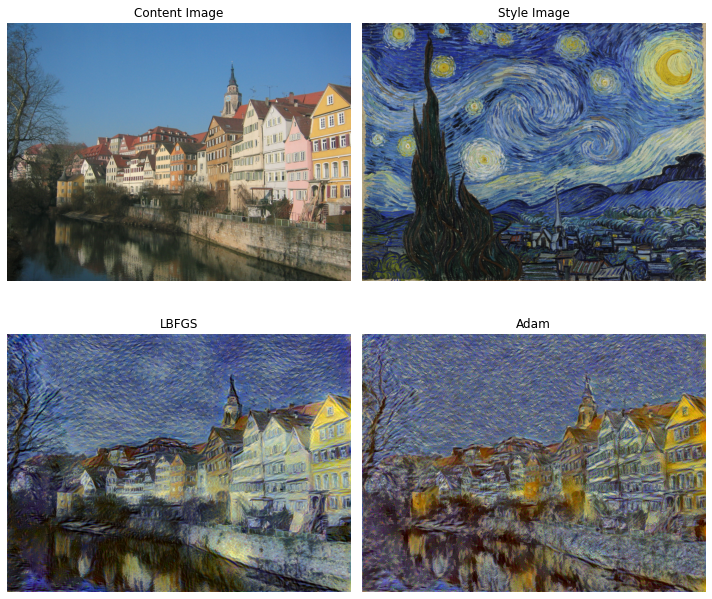

In [172]:
content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Tuebingen_Neckarfront.jpg"
style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Starry_Night.jpg"
# content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/dancing.jpg"
# style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/picasso.jpg"
# style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Tuebingen_Neckarfront.jpg"
# content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/building.jpg"
# content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/women2.jpg"
# style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/wave2.jpg"
# style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/brushstrokes.jpg"
content_img, style_img = load_images(content_img_path, style_img_path)

# hyperparameters
content_layer = {
    # "19": "conv4_1",
    # "28": "conv5_1",
    '21': 'conv4_2',  
    }
style_layer = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
    }
attention_style_layer={
    # '10': 'conv3_1',
    # '12': 'conv3_2',
    # '16': 'conv3_4',
    '19': 'conv4_1',
    # '21': 'conv4_2', 
    # '24': 'conv4_3', 
    # '25': 'conv4_4',
    # '5': 'conv2_1', # no enough memory for softmax
    # '28': 'conv5_1',
    # '30': 'conv5_2',
}
# attention_style_use_layer={
#     '28': 'conv5_1',
# }
# 5 7e7
content_weight=1
style_weight=1e6
attention_weight=5e6
content_layer_weights = None
style_layer_weights=[0.2, 0.2, 0.2, 0.2, 0.2]
attention_layer_weights = None

output, runtime = run_style_transfer(cnn, content_img, style_img, num_steps=600, noise_ratio=1, 
                       content_weight=content_weight, style_weight=style_weight, attention_weight=attention_weight,
                       content_layer=content_layer, style_layer=style_layer, attention_style_layer=attention_style_layer,
                       content_layer_weights=content_layer_weights, style_layer_weights=style_layer_weights,
                       attention_layer_weights=attention_layer_weights)
# output = run_style_transfer(cnn, content_img, style_img, num_steps=400, noise_ratio=1, 
#                        content_weight=content_weight, style_weight=style_weight, attention_weight=attention_weight,
#                        content_layer=content_layer, style_layer=style_layer, attention_style_layer=attention_style_layer, attention_style_use_layer=attention_style_use_layer,
#                        content_layer_weights=content_layer_weights, style_layer_weights=style_layer_weights,
#                        attention_layer_weights=attention_layer_weights)

# print(content_layer, style_layer, attention_style_layer, content_weight, style_weight, attention_weight)
fig, ax = plt.subplots(2, 2, figsize=(10, 9))
ax[0, 0].imshow(tensor_to_numpy(content_img))
ax[0, 0].axis(False)
ax[0, 0].set_title("Content Image")
ax[0, 1].imshow(tensor_to_numpy(style_img))
ax[0, 1].axis(False)
ax[0, 1].set_title("Style Image")
ax[1, 0].imshow(tensor_to_numpy(output))
ax[1, 0].axis(False)
ax[1, 0].set_title("LBFGS")
ax[1, 1].imshow(tensor_to_numpy(prev))
ax[1, 1].axis(False)
ax[1, 1].set_title("Adam")
plt.tight_layout()
runtime

no att
{'21': 'conv4_2'} {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'} {'19': 'conv4_1'} 1 1000000.0 5000000.0


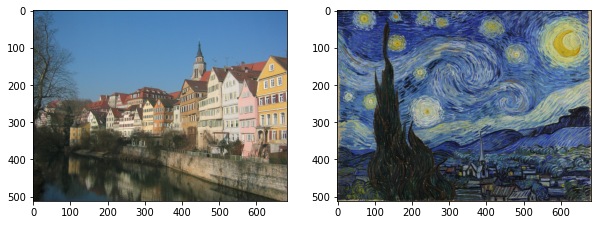

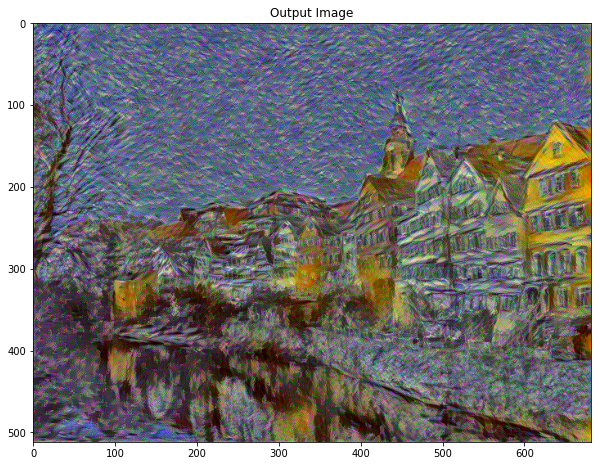

In [169]:
print("no att")
print(content_layer, style_layer, attention_style_layer, content_weight, style_weight, attention_weight,  )
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(tensor_to_numpy(content_img))
ax[1].imshow(tensor_to_numpy(style_img))
imshow(output, title='Output Image', figsize=(10,10));
prev = output


{'21': 'conv4_2'} {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'} {'19': 'conv4_1', '28': 'conv5_1'} 1 10000000.0 50000000.0


(-0.5, 511.5, 511.5, -0.5)

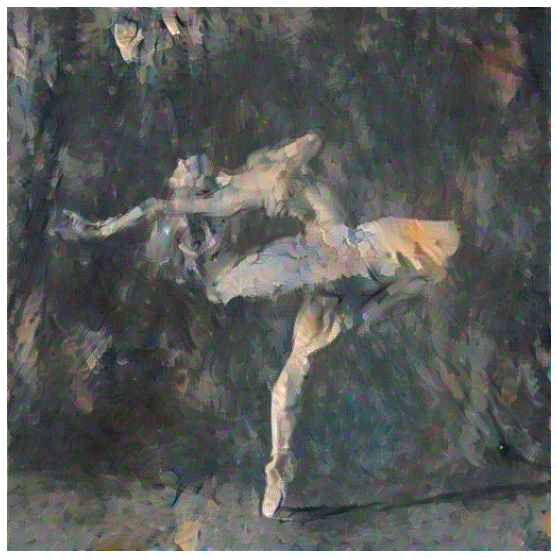

In [106]:
print(content_layer, style_layer, attention_style_layer, content_weight, style_weight, attention_weight,  )
plt.figure(figsize=(10,10))
plt.imshow(tensor_to_numpy(output))
plt.axis(False)
# ax[1, 0].set_title("Ours")
# ax[1, 1].imshow(tensor_to_numpy(prev))
# ax[1, 1].axis(False)

In [19]:
torch.cuda.empty_cache()
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

{'21': 'conv4_2'} {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'} {'30': 'conv5_2'} 1 10000000.0 0


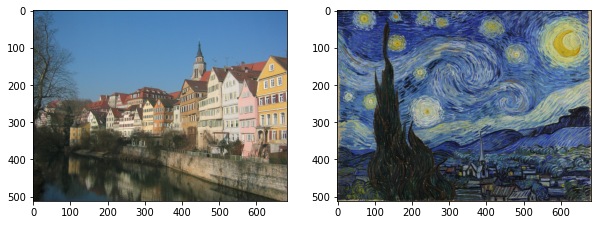

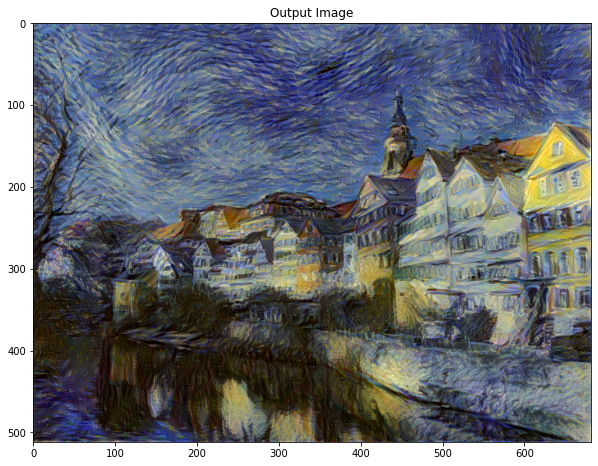

In [ ]:
print(content_layer, style_layer, attention_style_layer, content_weight, style_weight, attention_weight)
fig, ax = plt.subplots(1, 2, figsize=(10, 7))
ax[0].imshow(tensor_to_numpy(content_img))
ax[1].imshow(tensor_to_numpy(style_img))
imshow(output, title='Output Image', figsize=(10,10));

### Result of comparison

{'21': 'conv4_2'} {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'} {'19': 'conv4_1'} 1 10000000.0 6000000.0


21.445472955703735

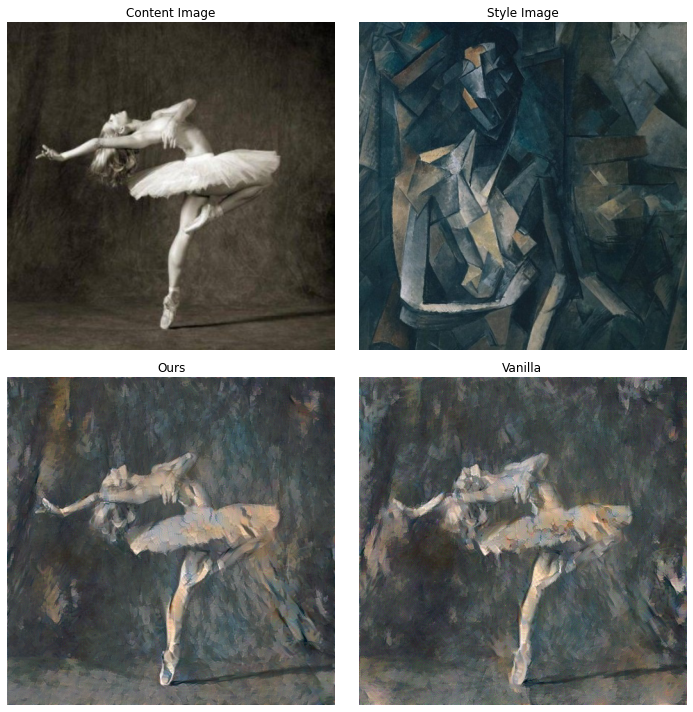

In [117]:
print(content_layer, style_layer, attention_style_layer, content_weight, style_weight, attention_weight)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(tensor_to_numpy(content_img))
ax[0, 0].axis(False)
ax[0, 0].set_title("Content Image")
ax[0, 1].imshow(tensor_to_numpy(style_img))
ax[0, 1].axis(False)
ax[0, 1].set_title("Style Image")
ax[1, 0].imshow(tensor_to_numpy(output))
ax[1, 0].axis(False)
ax[1, 0].set_title("Ours")
ax[1, 1].imshow(tensor_to_numpy(prev))
ax[1, 1].axis(False)
ax[1, 1].set_title("Vanilla")
plt.tight_layout()
runtime

### Visualize weight

In [204]:
content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Tuebingen_Neckarfront.jpg"
# style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Starry_Night.jpg"
# content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/dancing.jpg"
style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/picasso.jpg"
content_img, style_img = load_images(content_img_path, style_img_path)

content_layer = {
    # "19": "conv4_1",
    # "28": "conv5_1",
    '21': 'conv4_2',  
    }
style_layer = {
    '0': 'conv1_1',
    '5': 'conv2_1',
    '10': 'conv3_1',
    '19': 'conv4_1',
    '28': 'conv5_1'
    }
attention_style_layer={
    # '19': 'conv4_1',
    # '21': 'conv4_2', 
    # '28': 'conv5_1',
    '10': 'conv3_1',
}
content_features, _,  content_attention_features = get_features(content_img, cnn, content_layer, style_layer, attention_style_layer)
_, style_features, style_attention_features = get_features(style_img, cnn, content_layer, style_layer, attention_style_layer)
content_attention_features = content_attention_features["conv3_1"]
style_attention_features = style_attention_features["conv3_1"]

In [205]:
content_feature = content_attention_features.detach().clone()
style_feature = style_attention_features.detach().clone()
N,C,H,W = style_feature.shape
# style_feature = style_feature.view(H*W, C)
# content_feature = content_feature.view(C, H*W)
# softmax = torch.mm(style_feature, content_feature)
# softmax /= torch.max(softmax)//10
# softmax = torch.exp(softmax)

style_feature = style_feature.view(H*W, C)
content_feature = content_feature.view(H*W, C)
softmax = torch.mm(content_feature, style_feature.T)
softmax /= torch.max(softmax)//10
softmax = torch.exp(softmax)

In [206]:
style_feature.shape, softmax.shape, H,W

(torch.Size([21760, 256]), torch.Size([21760, 21760]), 128, 170)

In [214]:
# softmax = softmax.squeeze()
factor = 4
x_pos, y_pos = 14, 35

pos = x_pos*W + y_pos
# softmax = F.interpolate(softmax.unsqueeze(0).unsqueeze(0), scale_factor=1/4).squeeze()
highest = softmax[pos].argmax()
# x_pos2, y_pos2 = highest//(W//2), highest%(W//2)
x_pos2, y_pos2 = highest//(W), highest%(W)
x_pos2, y_pos2 = x_pos2.cpu().item(), y_pos2.cpu().item()

x_pos, y_pos = x_pos*factor, y_pos*factor
x_pos3, y_pos3 = x_pos2*factor, y_pos2*factor
print(softmax.shape)
row = softmax[pos].view(H, W)

torch.Size([21760, 21760])


In [215]:
x_pos, y_pos, pos, highest, x_pos2, y_pos2, row.max(), row[x_pos2, y_pos2]

(56,
 140,
 2415,
 tensor(3910, device='cuda:0'),
 23,
 0,
 tensor(2.1623, device='cuda:0'),
 tensor(2.1623, device='cuda:0'))

(-0.5, 169.5, 127.5, -0.5)

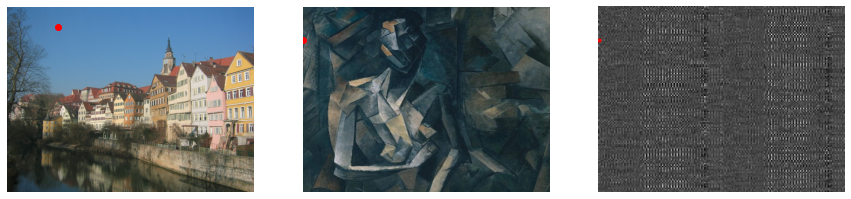

In [217]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(tensor_to_numpy(content_img))
ax[0].plot(y_pos, x_pos, "ro")
ax[0].axis(False)

ax[1].imshow(tensor_to_numpy(style_img))
ax[1].plot(y_pos3, x_pos3, "ro")
ax[1].axis(False)
ax[1].axis(False)
ax[2].imshow(row.cpu().squeeze(), "gray")
ax[2].plot(y_pos2, x_pos2, "r.")
ax[2].axis(False)
# ax[2].plot(370, 470, "o")

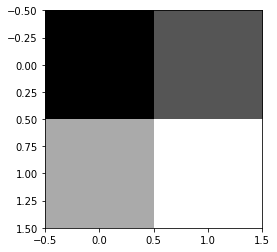

In [407]:
tt = np.array([1,2,3,4]).reshape(2,2)
plt.imshow(tt, cmap="gray")

### Another implementation
This is another implementation from pytorch, which is problematic since it only uses the first five layers

In [380]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    """
    A Sequential module contains an ordered list of child modules, including layers from VGG19
    and some of new layers in order to extract and conpute the content and style loss."""
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.AvgPool2d):
            name = 'ave_pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        # else:
        #     raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used to dynamically compute the gradient: 
        # this is a stated value, not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach().clone()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        # print("cont:", self.loss)
        return input

def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1); b=# feature maps; (c,d)=dimensions of a f. map
    features = input.view(b, c * d)  
    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach().clone() # the Gram matrix of style image is fixed

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        # print("style:", self.loss)
        return input
     
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    input_img = initialize_img(content_img)
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    display(model)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (ave_pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (ave_pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

Optimizing..
run [50]:
Style Loss : 0.945546 Content Loss: 3.699721

run [100]:
Style Loss : 0.635612 Content Loss: 2.970104

run [150]:
Style Loss : 0.466625 Content Loss: 2.872239

run [200]:
Style Loss : 0.429160 Content Loss: 2.814996

run [250]:
Style Loss : 0.445357 Content Loss: 2.869350

run [300]:
Style Loss : 3.950108 Content Loss: 4.594234

Time usage: 28.3016


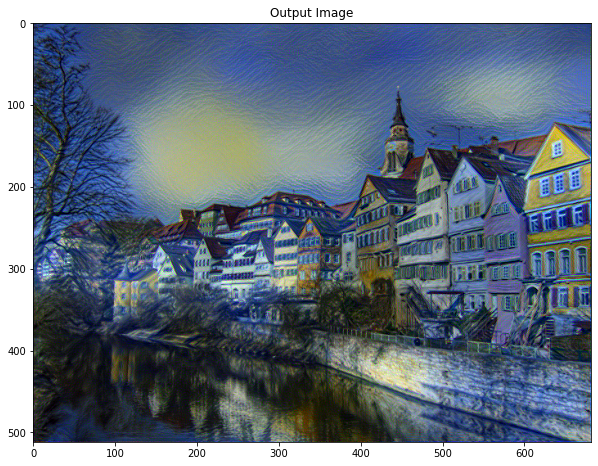

In [ ]:
start_time = time.time()
style_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Starry_Night.jpg"
content_img_path = "/content/drive/MyDrive/Colab Notebooks/Neural_style_transfer/images/Tuebingen_Neckarfront.jpg"
content_img, style_img = load_images(content_img_path, style_img_path)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, num_steps=300,
                       style_weight=1e5, content_weight=1)

print("Time usage: {:.4f}".format(time.time() - start_time))
imshow(output, title='Output Image', figsize=(10,10));

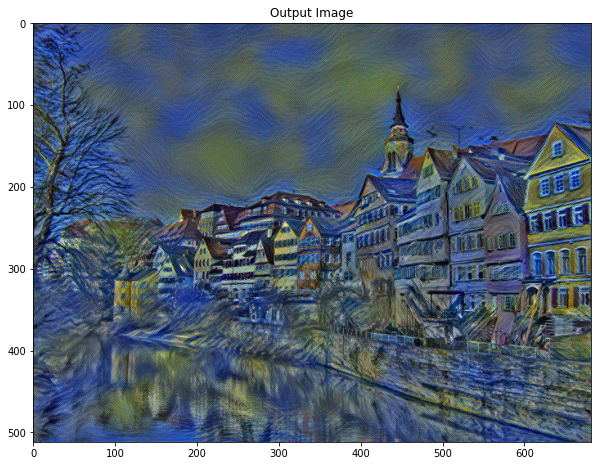

In [ ]:
imshow(output, title='Output Image', figsize=(10,10));